In [239]:
#!pip install geopandas

In [240]:
#!pip install folium

In [241]:
import numpy as np
import pandas as pd
import geopandas as gpd ## extension panda pour gérer des données géographiques
import folium ## permet de créer des cartes interactives
import requests ## pour faire des requêtes HTTP pour récupérer des données en ligne
from matplotlib import pyplot as plt ## partie de la bibliothèque Matplotlib utilisée pour faire des graphiques.
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler ## onctions de SciPy pour faire du clustering hiérarchique 

In [242]:
from shapely.geometry import Point ## Shapely est une bibliothèque Python utilisée pour manipuler des objets géométriques (points, lignes, polygones) dans un contexte géospatial.

Ouverture du fichier sur les données sociodémographiques des IRIS

In [243]:
revenus = pd.read_csv("data/revenus.csv", sep=";")
revenus.head()
## nous chargeons un fichier CSV nommé "revenus.csv" en utilisant la bibliothèque pandas et nous affichons les premières lignes du DataFrame résultant avec la méthode head().
## Ce tableau statistique de l'INSEE contient une colonne d'indentification géographique (IRIS) et de nombreuses colonnes de variables sur les revenus (médiane, déciles, quartiles, indices d’inégalité, parts de prestations, impôts, etc.) 

,IRIS,DISP_TP6018,DISP_Q118,DISP_MED18,DISP_Q318,DISP_EQ18,DISP_D118,DISP_D218,DISP_D318,DISP_D418,...,DISP_PCHO18,DISP_PBEN18,DISP_PPEN18,DISP_PPAT18,DISP_PPSOC18,DISP_PPFAM18,DISP_PPMINI18,DISP_PPLOGT18,DISP_PIMPOT18,DISP_NOTE18
0,010040101,20.1,14000.0,19300.0,25250.0,0.58,10340.0,13010.0,14970.0,17020.0,...,3.0,2.7,27.7,7.3,8.8,3.4,3.4,2.0,-15.1,0
1,010040102,25.7,12890.0,17530.0,23100.0,0.58,9970.0,12030.0,13710.0,15570.0,...,4.2,2.2,26.2,6.6,11.5,3.9,4.5,3.1,-13.8,0
2,010040201,19.1,14090.0,19580.0,26320.0,0.62,11000.0,13140.0,15170.0,17640.0,...,3.1,4.2,28.9,8.2,7.8,3.1,2.6,2.1,-15.8,0
3,010040202,8.9,18360.0,24530.0,31590.0,0.54,13600.0,17120.0,19550.0,21970.0,...,2.3,3.6,23.6,21.2,4.1,2.1,1.2,0.8,-20.3,0
4,010330102,18.6,14060.0,19960.0,28100.0,0.70,10230.0,13330.0,15420.0,17470.0,...,4.2,2.4,26.7,8.4,5.2,1.6,2.0,1.6,-14.7,0


In [244]:
revenus.columns = (
    revenus.columns
    .str.replace("^DISP_", "", regex=True)   # enlève le préfixe DISP_
    .str.replace("18$", "", regex=True)      # enlève le suffixe 18
    .str.lower()                             # met en minuscules
)
print(revenus.columns)
## Ici on nettoie les noms des colonnes du DataFrame en supprimant certains préfixes et suffixes spécifiques, et en convertissant tous les noms de colonnes en minuscules pour une meilleure lisibilité et cohérence. Ainsi on retir le préfixe "DISP_" et le suffixe "18" des noms de colonnes, puis on convertit tous les noms en minuscules. Enfin, on affiche les nouveaux noms de colonnes.

Index(['iris', 'tp60', 'q1', 'med', 'q3', 'eq', 'd1', 'd2', 'd3', 'd4', 'd6',
       'd7', 'd8', 'd9', 'rd', 's80s20', 'gi', 'pact', 'ptsa', 'pcho', 'pben',
       'ppen', 'ppat', 'ppsoc', 'ppfam', 'ppmini', 'pplogt', 'pimpot', 'note'],
      dtype='object')


 Ici on nettoie les noms des colonnes du DataFrame en supprimant certains préfixes et suffixes spécifiques, et en convertissant tous les noms de colonnes en minuscules pour une meilleure lisibilité et cohérence. Ainsi on retir le préfixe "DISP_" et le suffixe "18" des noms de colonnes, puis on convertit tous les noms en minuscules. Enfin, on affiche les nouveaux noms de colonnes.

CAH
Faire un indice synthétique pour pouvoir représenter facilement les caractéristiques structurelles des quartiers sur une carte

In [245]:
revenus.shape
## nombre de zones géographiques (lignes) et de variables (colonnes) dans le DataFrame revenus.

(12395, 29)

In [246]:
revenus.isna().sum()

iris         0
tp60      2881
q1           1
med          1
q3           1
eq           1
d1           1
d2           1
d3           1
d4           1
d6           1
d7           1
d8           1
d9           1
rd           1
s80s20       1
gi           1
pact         1
ptsa       440
pcho       440
pben       440
ppen         1
ppat         1
ppsoc        1
ppfam        1
ppmini       1
pplogt       1
pimpot       1
note         0
dtype: int64

In [247]:
# on retire la colonne IRIS qui correspond aux identifiants, 
# la colonne DISP_TP6018 (23% de NA) et la note de précaution
rev_cah = revenus.drop(columns=["iris", "tp60", "note", "d2", "d3", "d4", "d6", "d7", "d8"])
print(rev_cah.columns)

Index(['q1', 'med', 'q3', 'eq', 'd1', 'd9', 'rd', 's80s20', 'gi', 'pact',
       'ptsa', 'pcho', 'pben', 'ppen', 'ppat', 'ppsoc', 'ppfam', 'ppmini',
       'pplogt', 'pimpot'],
      dtype='object')


La commande revenus.isna().sum() sert à vérifier les valeurs manquantes dans ton DataFrame.revenus.isna() crée un tableau de la même taille que revenus où chaque cellule vaut :
- True si la valeur est manquante (NaN)
- False sinon
#.sum() fait la somme par colonne, donc on obtient le nombre de valeurs manquantes pour chaque colonne.

In [248]:
# on vérifie qu'on n'a que des valeurs numériques
rev_cah.dtypes

q1        float64
med       float64
q3        float64
eq        float64
d1        float64
d9        float64
rd        float64
s80s20    float64
gi        float64
pact      float64
ptsa      float64
pcho      float64
pben      float64
ppen      float64
ppat      float64
ppsoc     float64
ppfam     float64
ppmini    float64
pplogt    float64
pimpot    float64
dtype: object

In [249]:
# imputation des valeurs manquantes
for col in rev_cah.columns:
    rev_cah[col] = rev_cah[col].fillna(rev_cah[col].median())

# vérification
rev_cah.isna().sum()

## Ce code remplace toutes les valeurs manquantes par la médiane de leur colonne et vérifie ensuite qu’il n’en reste plus. Cela prépare les données pour l’analyse ou le clustering.

q1        0
med       0
q3        0
eq        0
d1        0
d9        0
rd        0
s80s20    0
gi        0
pact      0
ptsa      0
pcho      0
pben      0
ppen      0
ppat      0
ppsoc     0
ppfam     0
ppmini    0
pplogt    0
pimpot    0
dtype: int64

In [250]:
# normalisation
scaler = StandardScaler()
rev_scaled = scaler.fit_transform(rev_cah)

## La normalisation transforme les données pour que chaque colonne ait moyenne 0 et écart type 1, ce qui évite qu’une variable domine les autres et permet des analyses plus fiables.

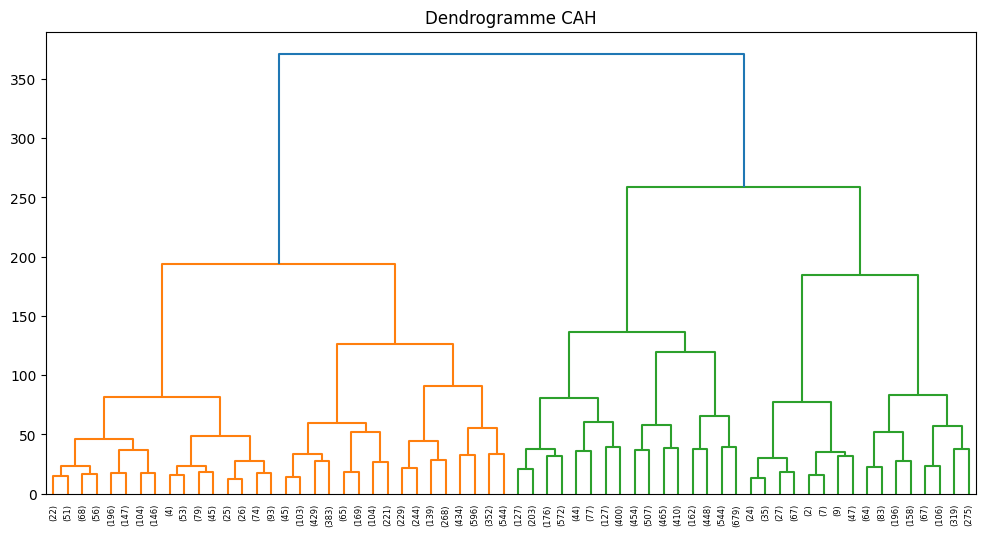

In [251]:
# CAH
Z = linkage(rev_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Dendrogramme CAH")
plt.show()

## Ce code réalise une Clustering Ascendant Hiérarchique (CAH) sur les données de revenus normalisées pour regrouper les IRIS aux caractéristiques similaires. La méthode de Ward est utilisée pour minimiser la variance à l’intérieur des clusters. Le dendrogramme affiché montre visuellement comment les IRIS sont regroupés et permet d’identifier le nombre de clusters pertinent pour analyser les profils socio-économiques des zones.*
## Expliquer comment on lit le dendrogramme

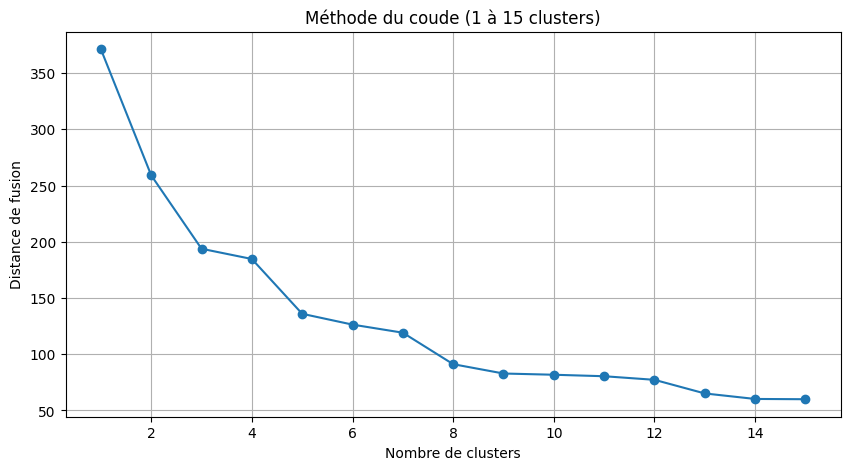

In [252]:
last = Z[:, 2]  # distances des fusions
last_rev = last[::-1]  # inversé pour l’ordre croissant

plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), last_rev[:15], marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Distance de fusion")
plt.title("Méthode du coude (1 à 15 clusters)")
plt.grid(True)
plt.show()

## On utilise la distance des fusions pour tracer une courbe et identifier le “coude”, c’est-à-dire le nombre de clusters où fusionner davantage devient peu utile. C’est une méthode visuelle et pratique pour déterminer le nombre optimal de clusters.
## L'axe x correspond au nombre de clusters et l'axe y à la distance de fusion (indique à quel point les clusters groupés sont différents). 

In [253]:
# 7. Découpage en clusters
clusters = fcluster(Z, 5, criterion='maxclust') ## on choisit 5 clusters
revenus["cluster"] = clusters

# Résumé
print(revenus["cluster"].value_counts()) ## affiche le nombre d'IRIS dans chaque cluster

vars_to_summarize = ["tp60", "med", "rd", "gi", "pact", "ppat", "ppsoc"] ## on utilise seulement certaines variables pour le résumé

summary = revenus.groupby("cluster")[vars_to_summarize].mean() ## pour chaque variable, on calcule la moyenne dans chaque cluster
total = revenus[vars_to_summarize].mean()
summary_with_total = pd.concat([summary, total.to_frame().T], axis=0)
summary_with_total.index = list(summary.index) + ["Total"]

print(summary_with_total)


cluster
3    5395
2    4325
5    1268
1    1189
4     218
Name: count, dtype: int64
            tp60           med        rd        gi       pact       ppat  \
1      46.129526  13728.637511  2.953070  0.246938  56.888394   3.586964   
2      25.916356  18086.376879  3.351561  0.267412  73.010289   5.688393   
3      13.514797  23488.464961  3.363033  0.275404  73.844123  10.537227   
4      10.473913  43935.458716  8.648165  0.502436  84.733945  34.336239   
5      11.989292  32169.834385  4.554968  0.332588  91.388644  12.943375   
Total  22.121242  21914.877360  3.534605  0.279728  73.913006   8.843190   

           ppsoc  
1      24.838772  
2      11.068231  
3       4.687968  
4       0.812844  
5       2.102839  
Total   8.514919  


Dans un premier temps, ce code attribue chaque IRIS à un cluster (le clustering se fait par rapport à toutes les variables).
Ensuite, ce code de résume les caractéristiques socio-économiques des clusters obtenus par la classification. Il compte d’abord combien d’IRIS appartiennent à chaque groupe, puis calcule la moyenne de plusieurs variables représentatives (revenu médian, inégalités, part d’actifs, etc.) pour chaque cluster. Il ajoute enfin la moyenne globale du dataset pour permettre une comparaison. Le tableau final permet donc de comprendre le profil typique de chaque cluster par rapport à l’ensemble du territoire.

In [254]:

summary2 = revenus.groupby("cluster")[vars_to_summarize].std() ## pour chaque variable, on calcule l'écart type dans chaque cluster
total2 = revenus[vars_to_summarize].std()
summary_with_total2 = pd.concat([summary2, total2.to_frame().T], axis=0)
summary_with_total2.index = list(summary2.index) + ["Total"]

print(summary_with_total2)

            tp60          med        rd        gi       pact       ppat  \
1       8.930982  1286.354175  0.488385  0.037087   8.391071   1.928095   
2       7.428217  2217.770814  0.675339  0.040119  10.453339   2.573626   
3       4.213479  2893.027145  0.722537  0.047807  11.384064   5.491072   
4       1.816724  5939.815822  2.447066  0.075455  11.402342  13.443496   
5       3.549261  4181.685901  1.073325  0.051189   7.463820   5.311759   
Total  12.065342  6311.463851  1.120379  0.058122  13.063074   6.508662   

          ppsoc  
1      7.154947  
2      3.843161  
3      1.769798  
4      0.306790  
5      0.903047  
Total  7.139598  


In [255]:
summary = revenus.groupby("cluster").mean(numeric_only=True) ## calculer la moyenne des colonnes numériques pour chaque cluster
total = revenus.mean(numeric_only=True) ## calculer la moyenne générale de toutes les colonnes numériques
summary_with_total = pd.concat([summary, total.to_frame().T], axis=0) ## crée un DataFrame avec les moyennes par cluster + une ligne summplémentaire avec la moyenne générale
summary_with_total.index = list(summary.index) + ["Total"]

print(summary_with_total)

            tp60            q1           med            q3        eq  \
1      46.129526  10465.189235  13728.637511  18489.798150  0.580690   
2      25.916356  13074.520231  18086.376879  24545.553757  0.630846   
3      13.514797  17320.986281  23488.464961  31347.951428  0.593521   
4      10.473913  25572.660550  43935.458716  73296.559633  1.080000   
5      11.989292  21913.257098  32169.834385  45705.402208  0.740276   
Total  22.121242  15796.406326  21914.877360  29947.380991  0.628886   

                 d1            d2            d3            d4            d6  \
1       8244.188394   9805.079899  11096.560135  12361.934399  15326.770395   
2       9697.239306  12060.157225  14059.780347  16031.364162  20329.528324   
3      12587.849462  15934.773823  18609.447534  21048.787542  26157.211717   
4      14710.596330  22177.018349  28959.678899  36127.844037  53225.596330   
5      14600.749211  19719.779180  24002.003155  28052.839117  36736.553628   
Total  11405.714055  

Après le clustering, chaque IRIS appartient à un groupe (cluster) ayant des caractéristiques similaires.

Le tableau summary montre les moyennes par cluster pour les variables importantes (revenu médian, déciles, parts de prestations, etc.).

Cela permet de comparer les clusters entre eux : par exemple, quel cluster a les revenus les plus élevés, ou les inégalités les plus fortes.

La ligne Total représente la moyenne globale pour toutes les données, sans distinction de cluster. Elle sert de référence pour savoir si un cluster est au-dessus ou en dessous de la moyenne générale.

In [256]:
cluster_order = revenus.groupby("cluster")["med"].median().sort_values()
print(cluster_order)
labels = ["tres_pauvre", "pauvre", "moyen", "riche", "tres_riche"]
mapping = {cluster: labels[i] for i, cluster in enumerate(cluster_order.index)}
mapping

cluster
1    13670.0
2    18040.0
3    23020.0
5    31935.0
4    43250.0
Name: med, dtype: float64


{1: 'tres_pauvre', 2: 'pauvre', 3: 'moyen', 5: 'riche', 4: 'tres_riche'}

In [257]:
revenus["cluster_label"] = revenus["cluster"].map(mapping)
print(revenus["cluster_label"].value_counts())

cluster_label
moyen          5395
pauvre         4325
riche          1268
tres_pauvre    1189
tres_riche      218
Name: count, dtype: int64


Fusionner avec les contours des IRIS

In [258]:
gdf_iris = gpd.read_file("contours-iris-pe.gpkg")

In [259]:
gdf_iris = gdf_iris.merge(
    revenus,
    left_on="code_iris",
    right_on="iris",
    how="left"
)
print(gdf_iris.columns)

Index(['cleabs', 'code_insee', 'nom_commune', 'iris_x', 'code_iris',
       'nom_iris', 'type_iris', 'geometry', 'iris_y', 'tp60', 'q1', 'med',
       'q3', 'eq', 'd1', 'd2', 'd3', 'd4', 'd6', 'd7', 'd8', 'd9', 'rd',
       's80s20', 'gi', 'pact', 'ptsa', 'pcho', 'pben', 'ppen', 'ppat', 'ppsoc',
       'ppfam', 'ppmini', 'pplogt', 'pimpot', 'note', 'cluster',
       'cluster_label'],
      dtype='object')


In [260]:
print(gdf_iris.isna().sum())
gdf_iris.shape

cleabs               0
code_insee           0
nom_commune          0
iris_x               0
code_iris            0
nom_iris             0
type_iris            0
geometry             0
iris_y           36506
tp60             39362
q1               36507
med              36507
q3               36507
eq               36507
d1               36507
d2               36507
d3               36507
d4               36507
d6               36507
d7               36507
d8               36507
d9               36507
rd               36507
s80s20           36507
gi               36507
pact             36507
ptsa             36943
pcho             36943
pben             36943
ppen             36507
ppat             36507
ppsoc            36507
ppfam            36507
ppmini           36507
pplogt           36507
pimpot           36507
note             36506
cluster          36506
cluster_label    36506
dtype: int64


(48512, 39)

In [261]:
pd.crosstab(gdf_iris["type_iris"], gdf_iris["cluster_label"], normalize="index", dropna=False)

cluster_label,moyen,pauvre,riche,tres_pauvre,tres_riche,NaN
type_iris,,,,,,
A,0.056166,0.053724,0.007326,0.007326,0.009768,0.865690
D,0.118380,0.031153,0.012461,0.000000,0.000000,0.838006
H,0.365255,0.284526,0.086966,0.069434,0.014552,0.179267
Z,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


On remarque que les iris de type "Z" ("autres") n'ont pas de valeurs, de même que la plupart des iris "A" ("activité") et D ("divers" : il s'agit de grandes zones spécifiques peu habitées et ayant une superficie importante (parcs de loisirs, zones portuaires, forêts, ...).), mais les IRIS H ("habitat") ont presque tous des valeurs concernant les revenus des habitants. Les données de l'INSEE disponibles concernent probablement seulement les quartiers qui ont beaucoup d'habitants pour des raisons de protection des données personnelles. Pour qu'on puisse utiliser ces données par la suite, il faudra vérifier que les formations post-bac se trouvent majoritairement dans des quartiers pour lesquelles ces données sont disponibles.

Données démographiques sur les IRIS

In [262]:
population = pd.read_csv("data/population.csv", sep=";")
population.head()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10272\2804659189.py:1: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  population = pd.read_csv("data/population.csv", sep=";")


,IRIS,COM,TYP_IRIS,LAB_IRIS,P21_POP,P21_POP0002,P21_POP0305,P21_POP0610,P21_POP1117,P21_POP1824,...,C21_F15P_CS4,C21_F15P_CS5,C21_F15P_CS6,C21_F15P_CS7,C21_F15P_CS8,P21_POP_FR,P21_POP_ETR,P21_POP_IMM,P21_PMEN,P21_PHORMEN
0,10010000,1001,Z,5,832.000000,32.222177,27.437983,54.841845,79.169950,29.129798,...,48.268044,82.300710,29.021493,86.221404,29.019651,822.287126,9.712874,18.381010,832.000000,0.000000
1,10020000,1002,Z,5,267.000000,5.987773,12.067776,19.066467,34.050318,11.243816,...,24.612439,14.669749,4.740840,23.561105,4.740840,265.991895,1.008105,2.875822,267.000000,0.000000
2,10040101,1004,H,1,1796.951774,77.519678,43.974406,98.916060,122.511553,349.080836,...,86.476162,260.729950,37.654830,188.843991,121.113704,1538.646170,258.305605,211.469193,1433.950633,363.001141
3,10040102,1004,H,1,3837.421806,148.643017,157.192812,250.217020,321.725625,386.552428,...,175.460727,393.281535,131.385824,380.956440,311.474728,3276.844923,560.576883,704.822358,3837.421806,0.000000
4,10040201,1004,H,1,4393.228271,188.021595,181.999303,251.490070,393.474368,374.897947,...,306.603551,474.298207,188.919252,607.301110,366.136778,3939.798979,453.429292,476.166500,4305.227994,88.000277


In [296]:
print(population.shape)

(49280, 78)


In [263]:
population.columns = (
    population.columns
    .str.replace("^P21_", "", regex=True)   # enlève le préfixe DISP_
    .str.replace("^C21_", "", regex=True)      # enlève le suffixe 18
    .str.lower()                             # met en minuscules
)
print(population.columns)

Index(['iris', 'com', 'typ_iris', 'lab_iris', 'pop', 'pop0002', 'pop0305',
       'pop0610', 'pop1117', 'pop1824', 'pop2539', 'pop4054', 'pop5564',
       'pop6579', 'pop80p', 'pop0014', 'pop1529', 'pop3044', 'pop4559',
       'pop6074', 'pop75p', 'pop0019', 'pop2064', 'pop65p', 'poph', 'h0014',
       'h1529', 'h3044', 'h4559', 'h6074', 'h75p', 'h0019', 'h2064', 'h65p',
       'popf', 'f0014', 'f1529', 'f3044', 'f4559', 'f6074', 'f75p', 'f0019',
       'f2064', 'f65p', 'pop15p', 'pop15p_cs1', 'pop15p_cs2', 'pop15p_cs3',
       'pop15p_cs4', 'pop15p_cs5', 'pop15p_cs6', 'pop15p_cs7', 'pop15p_cs8',
       'h15p', 'h15p_cs1', 'h15p_cs2', 'h15p_cs3', 'h15p_cs4', 'h15p_cs5',
       'h15p_cs6', 'h15p_cs7', 'h15p_cs8', 'f15p', 'f15p_cs1', 'f15p_cs2',
       'f15p_cs3', 'f15p_cs4', 'f15p_cs5', 'f15p_cs6', 'f15p_cs7', 'f15p_cs8',
       'pop_fr', 'pop_etr', 'pop_imm', 'pmen', 'phormen'],
      dtype='object')


Fusion des bases de données : avec le code iris directement codé, on obtient principalement des NA. On cherche donc les codes iris présents dans les meta données de la base pour que la fusion fonctionne.

In [264]:
meta = pd.read_csv("data/meta_population.csv", sep=";")

# garder seulement les lignes correspondant à la variable IRIS
meta_iris = meta[meta["COD_VAR"] == "IRIS"]

# ne garder que le code et le nom
meta_iris = meta_iris[["COD_MOD", "LIB_MOD"]]

In [265]:
meta_iris["COD_MOD"] = (
    meta_iris["COD_MOD"].astype(str)
                        .apply(lambda x: x[1:] if x.startswith("0") else x)
)

population["iris"] = population["iris"].astype(str)
meta_iris["COD_MOD"] = meta_iris["COD_MOD"].astype(str)

population = population.merge(
    meta_iris,
    left_on="iris",
    right_on="COD_MOD",
    how="left"
)

In [266]:
gdf_iris = gdf_iris.merge(
    population,
    left_on="code_iris",
    right_on="COD_MOD",
    how="left"
)

print(gdf_iris[["pop", "pop_fr"]].isna().sum())
gdf_iris.shape

pop       3826
pop_fr    3826
dtype: int64


(48512, 117)

On donne un nom aux types d'iris

In [267]:
mapping_typ_iris = {
    "H": "habitat",
    "A": "activité",
    "D": "divers",
    "Z": "autre"
}

gdf_iris["type_iris_label"] = gdf_iris["type_iris"].map(mapping_typ_iris)
gdf_iris["type_iris_label"].value_counts()

type_iris_label
autre       32941
habitat     14431
activité      819
divers        321
Name: count, dtype: int64

In [294]:
gdf_iris.groupby("type_iris_label")["pop"].apply(lambda x: x.isna().sum())

type_iris_label
activité      21
autre       3053
divers        17
habitat      735
Name: pop, dtype: int64

Encore une fois, ce sont principalement les iris "autres" qui ont souvent pas de données. On n'a pas de correspondance parfaite non plus pour les autres, probablement en raison des changements des IRIS entre les différentes bases de données selon l'année de référence, mais les tables de passage des codes IRIS ne sont pas disponibles pour les années récentes.

Ouverture du fichier parcoursup

In [300]:
df = pd.read_csv("data/parcoursup.csv", sep=";")
df.head()

,Session,"Statut de l’établissement de la filière de formation (public, privé…)",Code UAI de l'établissement,Établissement,Code départemental de l’établissement,Département de l’établissement,Région de l’établissement,Académie de l’établissement,Commune de l’établissement,Filière de formation,...,tri,cod_aff_form,Concours communs et banque d'épreuves,Lien de la formation sur la plateforme Parcoursup,Taux d’accès,Part des terminales générales qui étaient en position de recevoir une proposition en phase principale,Part des terminales technologiques qui étaient en position de recevoir une proposition en phase principale,Part des terminales professionnelles qui étaient en position de recevoir une proposition en phase principale,etablissement_id_paysage,composante_id_paysage
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,2_Lycées,10463,NaN,https://dossier.parcoursup.fr/Candidats/public...,53.0,33.0,28.0,38.0,NaN,NaN
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,2_Lycées,10489,NaN,https://dossier.parcoursup.fr/Candidats/public...,99.0,19.0,52.0,28.0,NaN,NaN
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,2_Lycées,10577,NaN,https://dossier.parcoursup.fr/Candidats/public...,62.0,34.0,51.0,15.0,NaN,NaN
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,2_Lycées,10596,NaN,https://dossier.parcoursup.fr/Candidats/public...,72.0,31.0,37.0,32.0,NaN,NaN
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,1_universités,10654,NaN,https://dossier.parcoursup.fr/Candidats/public...,93.0,88.0,12.0,0.0,hlX1r,NaN


In [314]:
rename_dict = {
    "Statut de l’établissement de la filière de formation (public, privé…)": "secteur",
    "Établissement": "etab",
    "Code départemental de l’établissement": "dep",
    "Région de l’établissement": "reg",
    "Académie de l’établissement": "academie",
    "Académie de l’établissement": "academie",
    "Commune de l’établissement": "commune",
    "Filière de formation détaillée": "filiere_det",
    "Sélectivité": "selectivite",
    "Filière de formation très agrégée": "type_form",
    "Filière de formation détaillée bis": "filiere",
    "Coordonnées GPS de la formation": "coord_gps",
    "Capacité de l’établissement par formation": "nb_etud",
    "Effectif total des candidats pour une formation": "nb_cand",
    "Effectif total des candidats ayant accepté la proposition de l’établissement (admis)": "nb_admis",
    "Dont effectif des candidates admises": "nb_fille",
    "Dont effectif des admis boursiers néo bacheliers": "nb_boursier",
    "Effectif des admis néo bacheliers généraux": "nb_general",
    "Effectif des admis néo bacheliers technologiques": "nb_techno",
    "Effectif des admis néo bacheliers professionnels": "nb_pro",
    "Dont effectif des admis néo bacheliers sans mention au bac": "nb_sansmention",
    "Dont effectif des admis néo bacheliers avec mention Assez Bien au bac": "nb_abien",
    "Dont effectif des admis néo bacheliers avec mention Bien au bac": "nb_bien",
    "Dont effectif des admis néo bacheliers avec mention Très Bien au bac": "nb_tbien",
    "Dont effectif des admis néo bacheliers avec mention Très Bien avec félicitations au bac": "nb_felicitations",
    "Dont effectif des admis issus de la même académie": "nb_memeac",
    "Dont effectif des admis issus de la même académie (Paris/Créteil/Versailles réunies)": "nb_memeac2",
    "% d’admis néo bacheliers boursiers": "admis_boursier",
    "Taux d’accès": "taux_acces"
}

In [315]:
df = df.rename(columns=rename_dict)
colonnes_a_garder = [
    "secteur", "etab", "dep", "reg", "academie", "commune",
    "filiere_det", "selectivite", "type_form", "filiere",
    "coord_gps", "nb_etud", "nb_cand", "nb_admis",
    "nb_fille", "nb_boursier", "nb_general", "nb_techno", "nb_pro",
    "nb_sansmention", "nb_abien", "nb_bien", "nb_tbien", "nb_felicitations",
    "nb_memeac", "nb_memeac2", "admis_boursier", "taux_acces"
]
df = df[colonnes_a_garder]
print(df.columns)

Index(['secteur', 'etab', 'dep', 'reg', 'academie', 'commune', 'filiere_det',
       'selectivite', 'type_form', 'filiere', 'coord_gps', 'nb_etud',
       'nb_cand', 'nb_admis', 'nb_fille', 'nb_boursier', 'nb_general',
       'nb_techno', 'nb_pro', 'nb_sansmention', 'nb_abien', 'nb_bien',
       'nb_tbien', 'nb_felicitations', 'nb_memeac', 'nb_memeac2',
       'admis_boursier', 'taux_acces'],
      dtype='object')


Relier les IRIS à parcoursup

In [316]:
df[['latitude', 'longitude']] = df['coord_gps'].str.split(',', expand=True)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

# Vérifier
df[['latitude','longitude']].head()

,latitude,longitude
0,43.9486,4.81628
1,46.8655,-1.02739
2,46.8021,0.54320
3,46.5886,0.36542
4,46.8350,0.53499


In [272]:
df_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"   # CRS WGS84 pour des coordonnées GPS
)

df_points[['geometry']].head()

,geometry
0,POINT (4.81628 43.9486)
1,POINT (-1.02739 46.8655)
2,POINT (0.5432 46.8021)
3,POINT (0.36542 46.5886)
4,POINT (0.53499 46.835)


In [273]:
# Transformation des IRIS en EPSG:4326
gdf_iris = gdf_iris.to_crs(epsg=4326)

# Vérifier le CRS
print(gdf_iris.crs)

EPSG:4326


In [274]:
df_points = df_points.set_crs(4326)
gdf_iris = gdf_iris.set_crs(4326)

df_total = gpd.sjoin(
    df_points, 
    gdf_iris[['code_iris', 'nom_iris', 'geometry', 'nom_commune', 'type_iris', "med", "rd", "ppsoc", "cluster_label", "pop", "pop1117", "pop1824", "pop15p_cs3", "pop15p_cs5", "pop15p_cs6", "pop_imm"]], 
    how="left",
    predicate="within"
)

df_total.head()

,session,statut_de_l’etablissement_de_la_filiere_de_formation_public_prive,code_uai_de_l_etablissement,etablissement,code_departemental_de_l’etablissement,departement_de_l’etablissement,region_de_l’etablissement,academie_de_l’etablissement,commune_de_l’etablissement,filiere_de_formation,...,rd,ppsoc,cluster_label,pop,pop1117,pop1824,pop15p_cs3,pop15p_cs5,pop15p_cs6,pop_imm
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,4.3,9.6,pauvre,2744.168077,186.769463,466.091795,355.983001,356.578766,146.811448,482.620524
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,2.4,3.1,moyen,1856.085646,123.925326,130.383684,142.649766,214.072810,267.753472,48.776036
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,2.7,28.9,tres_pauvre,1699.501850,224.077722,210.904210,4.999984,205.361376,207.640983,305.938940
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,2.9,20.4,pauvre,1609.542069,111.610676,184.693866,8.322252,289.051929,216.232024,403.636171
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,NaN,NaN,NaN,139.838862,9.529066,15.366672,4.438498,9.876994,13.607738,3.975899


In [293]:
print(df_total.isna()[["cluster_label", "pop", "pop_imm", "code_iris"]].sum())
print(df_total.shape)

cluster_label    3249
pop              1303
pop_imm          1303
code_iris         762
dtype: int64
(14079, 139)


In [276]:
df_total["code_iris"].value_counts()

code_iris
690290301    113
751124615     86
920500607     85
751135014     82
674821005     78
            ... 
871870103      1
786230000      1
792020103      1
594490102      1
705500106      1
Name: count, Length: 2975, dtype: int64

In [278]:
df_total["selectivite"].value_counts()

selectivite
formation sélective        10891
formation non sélective     3188
Name: count, dtype: int64

In [279]:
# 1. Nombre total de formations par IRIS
total_form = (
    df_total.groupby("code_iris")
      .size()
      .reset_index(name="nb_formations")
)

# 2. Nombre de formations sélectives par IRIS
selectives = (
    df_total[df_total["selectivite"] == "formation sélective"]
    .groupby("code_iris")
    .size()
    .reset_index(name="nb_form_sel")
)

# 3. Fusion des deux résultats
result = total_form.merge(selectives, on="code_iris", how="left")

# Les IRIS sans formation sélective → 0
result["nb_form_sel"] = result["nb_form_sel"].fillna(0).astype(int)

result.head(15)

,code_iris,nb_formations,nb_form_sel
0,010040101,3,3
1,010310000,6,6
2,010330202,1,1
3,010490000,1,1
4,010530103,5,5
5,010530201,4,0
6,010530202,1,1
7,010530203,3,3
8,010530301,10,10
9,010530302,6,6


In [280]:
for col in df_total.columns:
    if "taux" in col.lower():
        print(col)

taux_d’acces


In [281]:
df_total["taux_d’acces"].quantile([0.25, 0.333, 0.5, 0.75])

0.250    36.0
0.333    45.0
0.500    60.0
0.750    87.0
Name: taux_d’acces, dtype: float64

In [282]:
(df_total["taux_d’acces"] < 50).mean()

np.float64(0.38383407912493783)

In [283]:
df_total["percent_d’admis_neo_bacheliers_boursiers"].quantile([0.25, 0.333, 0.5, 0.667, 0.75])

0.250    12.0
0.333    16.0
0.500    23.0
0.667    32.0
0.750    37.0
Name: percent_d’admis_neo_bacheliers_boursiers, dtype: float64

In [284]:
(df_total["percent_d’admis_neo_bacheliers_boursiers"] < 30).mean()

np.float64(0.628808864265928)

In [285]:
# créer les colonnes pour les formations très sélectives et avec un haut taux de boursiers
df_total["tres_select"] = df_total["taux_d’acces"] < 50
df_total["bcp_boursiers"] = df_total["percent_d’admis_neo_bacheliers_boursiers"] > 30

# compter par IRIS
result2 = df_total.groupby("code_iris")[["tres_select", "bcp_boursiers"]].sum().reset_index()

# fusionner aux autres colonnes créées 
result3 = result.merge(result2, on="code_iris", how="left")

# afficher
result3

,code_iris,nb_formations,nb_form_sel,tres_select,bcp_boursiers
0,010040101,3,3,0,2
1,010310000,6,6,0,1
2,010330202,1,1,1,1
3,010490000,1,1,0,1
4,010530103,5,5,0,3
...,...,...,...,...,...
2970,955850115,6,6,4,5
2971,956070105,1,1,1,0
2972,956070106,2,2,2,2
2973,956370101,6,6,3,2


Ajouter ces colonnes à la base sur les iris

In [286]:
gdf_iris = gdf_iris.merge(result3, on="code_iris", how="left")
gdf_iris[["nb_formations", "nb_form_sel", "tres_select", "bcp_boursiers"]].head(15)

,nb_formations,nb_form_sel,tres_select,bcp_boursiers
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,4.0,4.0,4.0,3.0
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [287]:
# Remplacer les NaN par 0 pour les colonnes issues des données parcoursup
gdf_iris["nb_formations"] = gdf_iris["nb_formations"].fillna(0)

# Vérification
gdf_iris["nb_formations"].head(30)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     4.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    9.0
24    0.0
25    0.0
26    0.0
27    1.0
28    0.0
29    0.0
Name: nb_formations, dtype: float64

In [288]:
gdf_iris["nb_formations_cat"] = "0"

# sélectionner les valeurs > 0
mask = gdf_iris["nb_formations"] > 0

# créer les quantiles sur le reste
gdf_iris.loc[mask, "nb_formations_cat"] = pd.qcut(gdf_iris.loc[mask, "nb_formations"], 
                                            q=2, 
                                            labels=["Q1","Q2"])

gdf_iris.groupby("nb_formations_cat")["pop"].mean()

nb_formations_cat
0     1289.238894
Q1    2702.749689
Q2    2794.874234
Name: pop, dtype: float64

In [289]:
# Centrer la carte sur Besançon
besancon_lon, besancon_lat = 6.025, 47.237
m = folium.Map(location=[besancon_lat, besancon_lon], zoom_start=13)

# Ajouter les polygones IRIS
folium.GeoJson(
    gdf_iris,
    name="IRIS",
    style_function=lambda x: {"fillColor": "blue", "color": "black", "weight": 1, "fillOpacity": 0.2}
).add_to(m)

# Filtrer les points valides
df_points_valid = df_points.dropna(subset=['latitude', 'longitude'])

#Boucle sur les points valides
for idx, row in df_points_valid.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Ajouter contrôle des couches
folium.LayerControl().add_to(m)

# Afficher la carte
#m

In [290]:
# 1) Ajouter un code département à partir du code IRIS
gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

# 2) Garder uniquement l'Île-de-France
idf_deps = ["75", "77", "78", "91", "92", "93", "94", "95"]
gdf_idf = gdf_iris[gdf_iris["code_dept"].isin(idf_deps)].copy()

print("Nombre d'IRIS en IDF :", gdf_idf.shape[0])

# 3) Palette de couleurs pour les types de quartiers (clusters)
cluster_colors = {
    "tres_pauvre": "#b30000",  # rouge foncé
    "pauvre":      "#fc8d59",  # orange
    "moyen":       "#fee08b",  # jaune
    "riche":       "#91bfdb",  # bleu clair
    "tres_riche":  "#4575b4",  # bleu foncé
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    color = cluster_colors.get(label, "#cccccc")  # gris si NaN
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# 4) Filtrer les formations qui sont dans un IRIS IDF
idf_iris_codes = set(gdf_idf["code_iris"].astype(str).unique())

df_points_idf = df_total[
    df_total["code_iris"].astype(str).isin(idf_iris_codes)
].dropna(subset=["latitude", "longitude"])

print("Nombre de formations en IDF :", df_points_idf.shape[0])

# 5) Créer une carte centrée sur Paris
m = folium.Map(
    location=[48.8566, 2.3522],
    zoom_start=10,
    max_zoom=10,
    min_zoom=10,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    zoomControl=False
)


# 6) Ajouter les polygones IRIS colorés selon le type de quartier
folium.GeoJson(
    gdf_idf,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# 7) Ajouter les formations en points rouges
for _, row in df_points_idf.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

folium.LayerControl().add_to(m)
#m
print("ok")

Nombre d'IRIS en IDF : 5265
Nombre de formations en IDF : 2593
ok


In [291]:
## hello 

In [292]:
import statsmodels.formula.api as smf
# Construire la variable dépendante binaire Y = has_selective
# nb_form_sel = nombre de formations "formation sélective" dans l'IRIS (calculé plus haut)
# Si nb_form_sel est manquant (IRIS sans formation), on met 0.
gdf_iris["nb_form_sel"] = gdf_iris["nb_form_sel"].fillna(0)

# Variable binaire : 1 si au moins une formation sélective, 0 sinon
gdf_iris["has_selective"] = (gdf_iris["nb_form_sel"] > 0).astype(int)

print("Répartition de has_selective (0/1) :")
print(gdf_iris["has_selective"].value_counts(dropna=False))


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
#Construire un dataframe d'estimation propre (sans géométrie)
# Un logit ne doit pas recevoir la colonne geometry (qui n'est pas numérique)
# On garde uniquement les colonnes utiles au modèle.
# Ici, le coeur du modèle : C(cluster_label)
# Et (optionnel) quelques contrôles démographiques/sociaux.
vars_cont = ["ppsoc", "med", "pop1824","pop15p_cs5"] 
# Colonnes catégorielles : cluster_label (obligatoire), type_iris_label (optionnel si dispo)
cat_vars = ["cluster_label"]
if "type_iris_label" in gdf_iris.columns:
    cat_vars.append("type_iris_label")

# Colonnes finales utilisées
cols_needed = ["has_selective"] + cat_vars + [v for v in vars_cont if v in gdf_iris.columns]

df_model = gdf_iris[cols_needed].copy()

# Nettoyage : on enlève les lignes avec NA sur les variables du modèle
df_model = df_model.dropna()

print("\nColonnes utilisées dans df_model :")
print(df_model.columns.tolist())
print("Taille de l'échantillon :", df_model.shape)

In [ ]:
# Spécifier le modèle logit (formule)
# C(cluster_label) indique à statsmodels que cluster_label est catégorielle (dummies auto)
# La catégorie de référence est choisie automatiquement (souvent ordre alphabétique).
# Si tu veux imposer une référence (ex. "tres_pauvre"), on peut le faire ensuite.
terms = ["C(cluster_label, Treatment(reference='moyen'))"]

# Ajout de type_iris_label si présent
if "type_iris_label" in df_model.columns:
    terms.append("C(type_iris_label)")

# Ajout des contrôles continus disponibles
for v in vars_cont:
    if v in df_model.columns:
        terms.append(v)

formula = "has_selective ~ " + " + ".join(terms)
print("\nFormule estimée :")
print(formula)

In [ ]:
#Estimer le logit par maximum de vraisemblance

logit_model = smf.logit(formula=formula, data=df_model)
logit_results = logit_model.fit()

print("\nRésumé du logit :")
print(logit_results.summary())


Interprétation des résultats du modèle logit :

Le tableau ci-dessus présente les résultats d’un modèle logit estimant la probabilité pour un quartier (IRIS) d’accueillir au moins une formation sélective. La variable dépendante est binaire et vaut 1 si l’IRIS comporte au moins une formation sélective, 0 sinon. Le modèle est estimé par maximum de vraisemblance sur un échantillon de 11 424 IRIS et a convergé correctement.

Qualité globale du modèle:

Le test du rapport de vraisemblance (LLR p-value < 10⁻¹²⁰) permet de rejeter très nettement l’hypothèse nulle selon laquelle l’ensemble des coefficients seraient nuls. Le modèle explique donc significativement la présence de formations sélectives. Le pseudo-R² s’élève à environ 5,8 %, ce qui est un niveau courant pour un modèle logit appliqué à des données spatiales et suggère que, bien que le modèle capte une part non négligeable des déterminants, une fraction importante de la localisation des formations reste expliquée par des facteurs non observés.

Lecture des coefficients associés aux types de quartiers:

Les coefficients estimés pour les types de quartiers sont exprimés en *log-odds* et doivent être interprétés relativement à une catégorie de référence. Dans ce modèle, les quartiers de type *moyen* constituent la catégorie de référence. Ainsi, chaque coefficient mesure l’écart de probabilité d’accueillir une formation sélective entre un type de quartier donné et un quartier moyen, toutes choses égales par ailleurs.

Un coefficient négatif indique que le type de quartier considéré a une probabilité plus faible que les quartiers moyens d’accueillir une formation sélective, tandis qu’un coefficient positif indique une probabilité plus élevée. Pour faciliter l’interprétation, ces coefficients peuvent être exponentiés afin d’obtenir des *odds ratios*, qui indiquent le facteur multiplicatif des chances relatives par rapport à la catégorie de référence.

Effet du type socio-économique du quartier:

Les quartiers *pauvres* présentent une probabilité significativement plus faible que les quartiers moyens d’accueillir une formation sélective. Cet écart est encore plus prononcé pour les quartiers *très pauvres*, dont la probabilité est fortement réduite par rapport à celle des quartiers moyens.
À l’autre extrémité de la distribution, les quartiers *très riches* se distinguent nettement des quartiers moyens par une probabilité significativement plus élevée d’accueillir une formation sélective. L’exponentiation du coefficient associé montre que les chances relatives d’implantation y sont plus de deux fois supérieures à celles observées dans les quartiers moyens. En revanche, les quartiers *riches* ne diffèrent pas significativement des quartiers moyens au seuil de 5 %, suggérant que l’avantage spatial se concentre principalement dans les quartiers les plus favorisés, et non de manière monotone avec le niveau de richesse.

Ces résultats révèlent une forte non-linéarité des inégalités socio-spatiales : les quartiers très riches concentrent une part disproportionnée de l’offre sélective, tandis que les quartiers pauvres et très pauvres sont nettement désavantagés.

Effet du type fonctionnel de l’IRIS:

Le modèle contrôle également pour le type fonctionnel des IRIS. À caractéristiques socio-économiques comparables, les IRIS à dominante résidentielle (*habitat*) présentent une probabilité plus faible d’accueillir une formation sélective que les IRIS d’activité, ce qui reflète une logique d’implantation liée à la présence d’infrastructures universitaires et de pôles d’enseignement.

Variables de contrôle démographiques et sociales:

Parmi les variables continues, la population âgée de 18 à 24 ans a un effet positif et fortement significatif : les quartiers comptant davantage de jeunes adultes ont une probabilité plus élevée d’accueillir des formations sélectives, ce qui est cohérent avec une logique de proximité à la population étudiante.

Le revenu médian apparaît avec un coefficient négatif conditionnellement aux clusters de quartiers, ce qui suggère que l’effet du niveau de revenu est déjà largement capturé par la typologie socio-économique globale. De même, la part des cadres et la part des prestations sociales dans le revenu ne présentent pas d’effet significatif une fois ces typologies prises en compte, indiquant une redondance informationnelle avec les clusters.


In [ ]:
#Interpréter en odds ratios (plus lisible que les log-odds)
# Les coefficients du logit sont en log-odds.
# Exp(coef) donne un odds ratio : multiplicateur des odds quand la variable augmente.
odds_ratios = np.exp(logit_results.params).sort_values(ascending=False)

print("\nOdds ratios (exp(coefficients)) :")
print(odds_ratios)

In [ ]:
#ça on comprend pas comment ça marche
#Calculer les probabilités prédites (p_hat) pour chaque IRIS du df_model
df_model["p_hat"] = logit_results.predict(df_model)

print("\nRésumé des probabilités prédites :")
print(df_model["p_hat"].describe())


In [ ]:
#Réinjecter les probabilités prédites dans gdf_iris pour cartographie
# On réassocie les p_hat à gdf_iris via l'index (car df_model vient de gdf_iris)
gdf_iris.loc[df_model.index, "p_hat"] = df_model["p_hat"]

print("\nColonne 'p_hat' ajoutée dans gdf_iris (extrait) :")
print(gdf_iris[["has_selective", "nb_form_sel", "cluster_label", "p_hat"]].head(10))